In [1]:
 # Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/ubuntu/fastai/')
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from glob2 import glob
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [3]:
f_model = resnet50
PATH = '/home/ubuntu/plants/Image-processing/'
label_csv ='labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n,val_pct=0.0)

In [4]:
def f1(preds, targs):
    preds = np.argmax(preds, 1)
    return f1_score(targs, preds, average='micro')

In [5]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz,aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    val_idxs=[0], test_name='test')

In [6]:
sz=256

In [7]:
data = get_data(256)

In [8]:
learn = ConvLearner.pretrained(f_model,data, ps=0.5,metrics=[f1],precompute= True)

100%|██████████| 76/76 [00:57<00:00,  1.32it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▋  | 58/76 [00:01<00:00, 40.25it/s, loss=10.2]


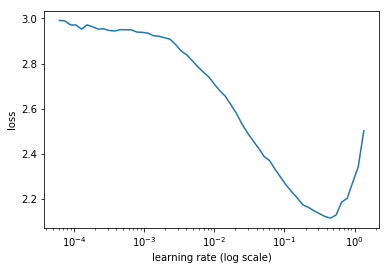

In [10]:
learn.lr_find()
learn.sched.plot()

In [11]:
lr =1e-2
lrs =np.array([lr/18,lr/6,lr/2])

In [12]:
learn.load('256')

While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([4096]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]), ...


RuntimeError: invalid argument 2: sizes do not match at /opt/conda/conda-bld/pytorch_1503965122592/work/torch/lib/THC/generic/THCTensorCopy.c:48

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=2, cycle_mult=3)
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=2, cycle_mult=3)

In [51]:
learn.save(f'{sz}')

In [47]:
pred,y = learn.TTA()

In [48]:
preds = np.mean(np.exp(pred),0)

In [50]:
f1(preds,y)

0.97578947368421054

In [52]:
submission, test_y = learn.TTA(is_test=True)

In [53]:
submission = np.mean(np.exp(submission),0)
submission = np.argmax(submission,axis=1)

In [57]:
func = np.vectorize(lambda x:data.classes[x])
species = func(submission)

In [60]:
submission_df = pd.DataFrame({'file': test_df, 'species': species})
submission_df.species.replace('_',' ',regex=True,inplace =True)
submission_df.to_csv('submission.csv.gz', compression = 'gzip',index=False)